# Use PPO to Play Acrobot-v1

TensorFlow version

In [1]:
%matplotlib inline

import sys
import logging
import imp
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import scipy.signal as signal
import gym
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers


imp.reload(logging)
logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])

03:33:25 [INFO] env: <AcrobotEnv<Acrobot-v1>>
03:33:25 [INFO] action_space: Discrete(3)
03:33:25 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
03:33:25 [INFO] reward_range: (-inf, inf)
03:33:25 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
03:33:25 [INFO] _max_episode_steps: 500
03:33:25 [INFO] _elapsed_steps: None


In [3]:
class PPOReplayer:
    def __init__(self):
        self.fields = ['state', 'action', 'pi', 'advantage', 'return']
        self.memory = pd.DataFrame(columns=self.fields)
    
    def store(self, df):
        self.memory = pd.concat([self.memory, df[self.fields]], ignore_index=True)
        
    def sample(self, size):
        indices = np.random.choice(self.memory.shape[0], size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class PPOAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        
        self.replayer = PPOReplayer()
        self.trajectory = []

        self.actor_net = self.build_net(hidden_sizes=[100,],
                output_size=self.action_n, output_activation=nn.softmax,
                learning_rate=0.001)
        self.critic_net = self.build_net(hidden_sizes=[100,],
                learning_rate=0.002)

    def build_net(self, input_size=None, hidden_sizes=None, output_size=1, 
                activation=nn.relu, output_activation=None,
                loss=losses.mse, learning_rate=0.001):
        model = keras.Sequential()
        for hidden_size in hidden_sizes:
            model.add(layers.Dense(units=hidden_size,
                    activation=activation))
        model.add(layers.Dense(units=output_size,
                activation=output_activation))
        optimizer = optimizers.Adam(learning_rate)
        model.compile(optimizer=optimizer, loss=loss)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        probs = self.actor_net.predict(observation[np.newaxis])[0]
        action = np.random.choice(self.action_n, p=probs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
        return action

    def close(self):
        if self.mode == 'train':
            self.save_trajectory_to_replayer()
            if len(self.replayer.memory) >= 1000:
                for batch in range(5): # learn multiple times
                    self.learn()
                self.replayer = PPOReplayer() # reset replayer after the agent changes itself

    def save_trajectory_to_replayer(self):
        df = pd.DataFrame(
                np.array(self.trajectory, dtype=object).reshape(-1, 4),
                columns=['state', 'reward', 'done', 'action'], dtype=object)
        states = np.stack(df['state'])
        df['v'] = self.critic_net.predict(states)
        pis = self.actor_net.predict(states)
        df['pi'] = [pi[action] for pi, action in zip(pis, df['action'])]
        df['next_v'] = df['v'].shift(-1).fillna(0.)
        df['u'] = df['reward'] + self.gamma * df['next_v']
        df['delta'] = df['u'] - df['v']
        df['advantage'] = signal.lfilter([1.,], [1., -self.gamma],
                df['delta'][::-1])[::-1]
        df['return'] = signal.lfilter([1.,], [1., -self.gamma],
                df['reward'][::-1])[::-1]
        self.replayer.store(df)

    def learn(self):
        states, actions, old_pis, advantages, returns = \
                self.replayer.sample(size=64)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        action_tensor = tf.convert_to_tensor(actions, dtype=tf.int32)
        old_pi_tensor = tf.convert_to_tensor(old_pis, dtype=tf.float32)
        advantage_tensor = tf.convert_to_tensor(advantages, dtype=tf.float32)
        
        # train actor net
        with tf.GradientTape() as tape:
            all_pi_tensor = self.actor_net(state_tensor)
            pi_tensor = tf.gather(all_pi_tensor, action_tensor, batch_dims=1)
            surrogate_advantage_tensor = (pi_tensor / old_pi_tensor) * \
                    advantage_tensor
            clip_times_advantage_tensor = 0.1 * surrogate_advantage_tensor
            max_surrogate_advantage_tensor = advantage_tensor + \
                    tf.where(advantage_tensor > 0.,
                    clip_times_advantage_tensor, -clip_times_advantage_tensor)
            clipped_surrogate_advantage_tensor = tf.minimum(
                    surrogate_advantage_tensor, max_surrogate_advantage_tensor)
            loss_tensor = -tf.reduce_mean(clipped_surrogate_advantage_tensor)
        actor_grads = tape.gradient(loss_tensor, self.actor_net.variables)
        self.actor_net.optimizer.apply_gradients(
                zip(actor_grads, self.actor_net.variables))

        # train critic
        self.critic_net.fit(states, returns, verbose=0)


agent = PPOAgent(env)

03:33:26 [INFO] ==== train ====
03:34:14 [DEBUG] train episode 0: reward = -500.00, steps = 500
03:34:14 [INFO] NumExpr defaulting to 8 threads.
03:35:03 [DEBUG] train episode 1: reward = -500.00, steps = 500
03:35:52 [DEBUG] train episode 2: reward = -500.00, steps = 500
03:36:40 [DEBUG] train episode 3: reward = -500.00, steps = 500
03:37:27 [DEBUG] train episode 4: reward = -485.00, steps = 486
03:38:14 [DEBUG] train episode 5: reward = -500.00, steps = 500
03:38:45 [DEBUG] train episode 6: reward = -339.00, steps = 340
03:39:27 [DEBUG] train episode 7: reward = -448.00, steps = 449
03:39:54 [DEBUG] train episode 8: reward = -292.00, steps = 293
03:40:29 [DEBUG] train episode 9: reward = -383.00, steps = 384
03:41:16 [DEBUG] train episode 10: reward = -500.00, steps = 500
03:41:42 [DEBUG] train episode 11: reward = -283.00, steps = 284
03:42:05 [DEBUG] train episode 12: reward = -254.00, steps = 255
03:42:30 [DEBUG] train episode 13: reward = -267.00, steps = 268
03:43:16 [DEBUG] tr

05:05:38 [DEBUG] train episode 125: reward = -254.00, steps = 255
05:06:11 [DEBUG] train episode 126: reward = -369.00, steps = 370
05:06:44 [DEBUG] train episode 127: reward = -371.00, steps = 372
05:07:30 [DEBUG] train episode 128: reward = -496.00, steps = 497
05:07:58 [DEBUG] train episode 129: reward = -316.00, steps = 317
05:08:28 [DEBUG] train episode 130: reward = -324.00, steps = 325
05:09:03 [DEBUG] train episode 131: reward = -388.00, steps = 389
05:09:41 [DEBUG] train episode 132: reward = -418.00, steps = 419
05:10:14 [DEBUG] train episode 133: reward = -359.00, steps = 360
05:10:59 [DEBUG] train episode 134: reward = -500.00, steps = 500
05:11:47 [DEBUG] train episode 135: reward = -500.00, steps = 500
05:12:21 [DEBUG] train episode 136: reward = -365.00, steps = 366
05:12:43 [DEBUG] train episode 137: reward = -238.00, steps = 239
05:13:13 [DEBUG] train episode 138: reward = -332.00, steps = 333
05:13:58 [DEBUG] train episode 139: reward = -500.00, steps = 500
05:14:35 [

05:46:31 [DEBUG] train episode 250: reward = -171.00, steps = 172
05:46:46 [DEBUG] train episode 251: reward = -162.00, steps = 163
05:47:03 [DEBUG] train episode 252: reward = -188.00, steps = 189
05:47:14 [DEBUG] train episode 253: reward = -124.00, steps = 125
05:47:33 [DEBUG] train episode 254: reward = -210.00, steps = 211
05:48:17 [DEBUG] train episode 255: reward = -500.00, steps = 500
05:48:32 [DEBUG] train episode 256: reward = -166.00, steps = 167
05:48:42 [DEBUG] train episode 257: reward = -111.00, steps = 112
05:48:55 [DEBUG] train episode 258: reward = -145.00, steps = 146
05:49:07 [DEBUG] train episode 259: reward = -141.00, steps = 142
05:49:19 [DEBUG] train episode 260: reward = -133.00, steps = 134
05:49:36 [DEBUG] train episode 261: reward = -187.00, steps = 188
05:49:48 [DEBUG] train episode 262: reward = -140.00, steps = 141
05:49:59 [DEBUG] train episode 263: reward = -118.00, steps = 119
05:50:12 [DEBUG] train episode 264: reward = -141.00, steps = 142
05:50:23 [

06:13:29 [DEBUG] test episode 24: reward = -134.00, steps = 135
06:13:50 [DEBUG] test episode 25: reward = -248.00, steps = 249
06:13:59 [DEBUG] test episode 26: reward = -111.00, steps = 112
06:14:11 [DEBUG] test episode 27: reward = -133.00, steps = 134
06:14:25 [DEBUG] test episode 28: reward = -173.00, steps = 174
06:14:37 [DEBUG] test episode 29: reward = -134.00, steps = 135
06:14:48 [DEBUG] test episode 30: reward = -132.00, steps = 133
06:14:58 [DEBUG] test episode 31: reward = -117.00, steps = 118
06:15:08 [DEBUG] test episode 32: reward = -115.00, steps = 116
06:15:19 [DEBUG] test episode 33: reward = -131.00, steps = 132
06:15:28 [DEBUG] test episode 34: reward = -98.00, steps = 99
06:15:40 [DEBUG] test episode 35: reward = -141.00, steps = 142
06:15:50 [DEBUG] test episode 36: reward = -119.00, steps = 120
06:15:59 [DEBUG] test episode 37: reward = -107.00, steps = 108
06:16:12 [DEBUG] test episode 38: reward = -149.00, steps = 150
06:16:23 [DEBUG] test episode 39: reward =

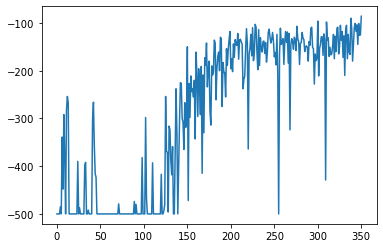

In [5]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [6]:
env.close()